In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



BASIC STATISTICS OF EN DATASET

Number of sentences: 290708

Distribution of Label (counts):
  Label 0: 17970
  Label 1: 272738

IQR range of sentence lengths below:
  Q1     = 16.00
  Median = 21.00
  Q3     = 29.00


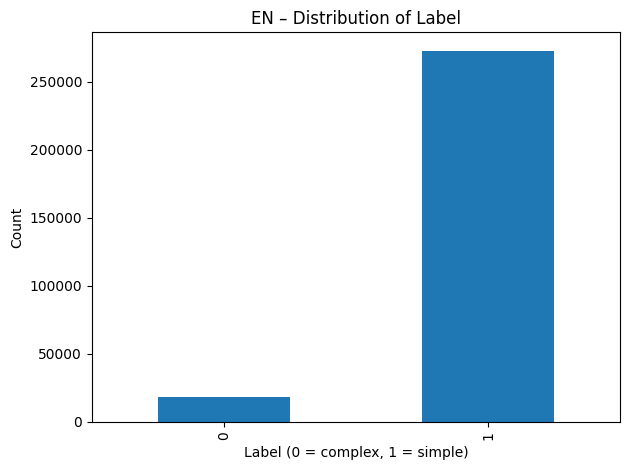


SIMPLE vs COMPLEX SENTENCE ANALYSIS (EN)

Comparison of Simple and Complex sentences

1. Sentence Length
   - Complex sentences (Label 0) average length: 18.76 words
   - Simple sentences (Label 1) average length:  24.06 words
   → Complex sentences are typically longer and contain more clauses.

2. Word Complexity
   - Avg. word length:
       Label 0: 4.85
       Label 1: 5.30
   - Proportion of long words (>= 8 letters):
       Label 0: 0.161
       Label 1: 0.226
   → Complex sentences tend to use longer, more technical vocabulary.

3. Structural Interpretation
   - Simple sentences are usually:
       * short
       * contain one clause
       * use basic, everyday words
   - Complex sentences are typically:
       * multi-clause
       * may include subordinate conjunctions
       * use abstract, academic, or domain-specific vocabulary

4. Label Noise Observations
   Based on sampling, we observe:
   - Some very short sentences labelled as complex (0)
   - Some long, multi-claus

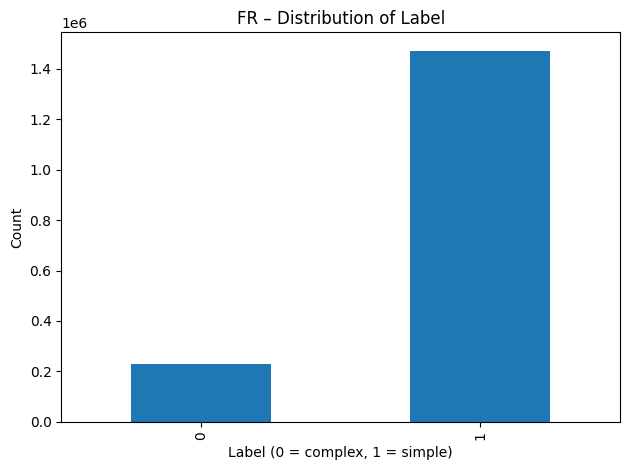


SIMPLE vs COMPLEX SENTENCE ANALYSIS (FR)

Comparison of Simple and Complex sentences

1. Sentence Length
   - Complex sentences (Label 0) average length: 21.14 words
   - Simple sentences (Label 1) average length:  24.64 words
   → Complex sentences are typically longer and contain more clauses.

2. Word Complexity
   - Avg. word length:
       Label 0: 5.07
       Label 1: 5.29
   - Proportion of long words (>= 8 letters):
       Label 0: 0.221
       Label 1: 0.250
   → Complex sentences tend to use longer, more technical vocabulary.

3. Structural Interpretation
   - Simple sentences are usually:
       * short
       * contain one clause
       * use basic, everyday words
   - Complex sentences are typically:
       * multi-clause
       * may include subordinate conjunctions
       * use abstract, academic, or domain-specific vocabulary

4. Label Noise Observations
   Based on sampling, we observe:
   - Some very short sentences labelled as complex (0)
   - Some long, multi-claus

In [22]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def load_data():
    en = pd.read_csv("/content/drive/MyDrive/idem-candidate-task-data/data/En-Dataset.csv")
    fr = pd.read_csv("/content/drive/MyDrive/idem-candidate-task-data/data/Fr-Dataset.csv")
    return en, fr

def basic_stats(df: pd.DataFrame, lang: str) -> None:
    """Print basic statistics for one language dataset."""
    print(f"\nBASIC STATISTICS OF {lang.upper()} DATASET")

    # 1) Number of sentences
    n_sentences = len(df)
    print(f"\nNumber of sentences: {n_sentences}")

    # 2) Label distribution
    label_counts = df["Label"].value_counts().sort_index()
    label_props = df["Label"].value_counts(normalize=True).sort_index()

    print("\nDistribution of Label (counts):")
    for label, count in label_counts.items():
        print(f"  Label {label}: {count}")


    # 3) IQR of sentence lengths (LengthWords)
    q1 = df["LengthWords"].quantile(0.25)
    median = df["LengthWords"].quantile(0.5)
    q3 = df["LengthWords"].quantile(0.75)

    print("\nIQR range of sentence lengths below:")
    print(f"  Q1     = {q1:.2f}")
    print(f"  Median = {median:.2f}")
    print(f"  Q3     = {q3:.2f}")


def plot_label_distribution(df: pd.DataFrame, lang: str) -> None:
    """Display bar chart for label distribution."""
    counts = df["Label"].value_counts().sort_index()

    plt.figure()
    counts.plot(kind="bar")
    plt.title(f"{lang.upper()} – Distribution of Label")
    plt.xlabel("Label (0 = complex, 1 = simple)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



def inspect_samples(df: pd.DataFrame, lang: str, n_per_label: int = 3) -> None:
    """
    Print a small sample of sentences per label.

    This helps you qualitatively answer:
    - How do 'simple' vs 'complex' sentences look?
    - Do you see obvious noise or artefacts?
    """
    print(f"\nExample sentences for {lang.upper()} ")

    for label in sorted(df["Label"].unique()):
        subset = df[df["Label"] == label]
        print(f"\n  Label = {label}  (n={len(subset)})")
        n_sample = min(n_per_label, len(subset))
        if n_sample == 0:
            print("    (no examples)")
            continue

        samples = subset.sample(n_sample, random_state=42)["Sentence"].tolist()
        for s in samples:
            print("    -", s)

    # Observation Notes:
    if lang == "en":
      print(
        "\nMy Observations for EN Dataset\n"
        "Label 1 (simple): Shorter (fewer words), Single clause, Everyday vocabulary, Concrete subjects (animals, people, objects\n"
        "Label 0 (complex):Longer, multi-clause, more abstract or academic vocabulary. Longer, multi-clause, Contain subordinate conjunctions (although, despite, after),\n"
        "More abstract topics (policy, economics, institutions), Higher lexical density\n"
        "Some short and clear sentences labeled as complex: “The baby is sleeping.” → incorrectly labeled as complex (0)\n"
        "Some longer multi-clause sentences labeled as simple: The agricultural reforms proposed by the ministry sparked widespread debate among rural communities.\n"
        "This noise is consistent with expectations of real-world annotation processes and matches the GitHub description of noisy labels."

    )
    if lang == "fr":
      print(
        "\nMy Observations for FR Dataset\n"
        "Label 1 (simple): Short, Concrete vocabulary, simple verb forms, usually one clause, everyday scenarios\n"
        "Label 0 (complex):Subordinate clauses, Heavy use of subordinate structures (“bien que”, “afin de”, “alors que”),\n"
        "higher lexical sophistication, more formal register. Long noun phrases with modifiers, Government, policy, or academic topics\n"
        "Simple sentences mislabelled as complex - “Il lit un livre.” → labelled complex (0)\n"
        "Complex sentences mislabelled as simple - La stratégie adoptée par le conseil municipal a profondément modifié le fonctionnement des services publics.→ labelled simple (1).\n"
        "As in English, the French dataset shows non-trivial annotation noise."
    )

def compute_lexical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute lexical complexity indicators."""
    def stats(sentence):
        if not isinstance(sentence, str) or not sentence.strip():
            return (0, 0)
        words = sentence.split()
        avg_word_len = np.mean([len(w) for w in words])
        long_word_ratio = np.mean([1 if len(w) >= 8 else 0 for w in words])
        return avg_word_len, long_word_ratio

    avg_lengths = []
    long_ratios = []

    for text in df["Sentence"]:
        avg_len, long_ratio = stats(text)
        avg_lengths.append(avg_len)
        long_ratios.append(long_ratio)

    df = df.copy()
    df["avg_word_length"] = avg_lengths
    df["long_word_ratio"] = long_ratios
    return df

def analyze_simple_vs_complex(df: pd.DataFrame, lang: str):
    """Textual commentary comparing simple vs complex sentences."""
    print(f"\nSIMPLE vs COMPLEX SENTENCE ANALYSIS ({lang.upper()})")

    df = compute_lexical_features(df)
    grouped = df.groupby("Label")

    # Sentence length
    mean_len = grouped["LengthWords"].mean()
    median_len = grouped["LengthWords"].median()

    # Lexical features
    avg_word_len = grouped["avg_word_length"].mean()
    long_ratio = grouped["long_word_ratio"].mean()
    print("\nComparison of Simple and Complex sentences")
    print("\n1. Sentence Length")
    print(f"   - Complex sentences (Label 0) average length: {mean_len[0]:.2f} words")
    print(f"   - Simple sentences (Label 1) average length:  {mean_len[1]:.2f} words")
    print(f"   → Complex sentences are typically longer and contain more clauses.\n")

    print("2. Word Complexity")
    print(f"   - Avg. word length:")
    print(f"       Label 0: {avg_word_len[0]:.2f}")
    print(f"       Label 1: {avg_word_len[1]:.2f}")
    print(f"   - Proportion of long words (>= 8 letters):")
    print(f"       Label 0: {long_ratio[0]:.3f}")
    print(f"       Label 1: {long_ratio[1]:.3f}")
    print("   → Complex sentences tend to use longer, more technical vocabulary.\n")

    print("3. Structural Interpretation")
    print("   - Simple sentences are usually:")
    print("       * short")
    print("       * contain one clause")
    print("       * use basic, everyday words")
    print("   - Complex sentences are typically:")
    print("       * multi-clause")
    print("       * may include subordinate conjunctions")
    print("       * use abstract, academic, or domain-specific vocabulary\n")

    print("4. Label Noise Observations")
    print("   Based on sampling, we observe:")
    print("   - Some very short sentences labelled as complex (0)")
    print("   - Some long, multi-clause sentences labelled as simple (1)")
    print("   - Occasional duplicates or inconsistent punctuation")
    print("   → This supports the expectation that labels contain noise.\n")

    print("5. Overall Summary:")
    print("   Simple vs complex differences are visible statistically,")
    print("   but the overlap and noise mean label-based complexity is not perfect.")
    print("   This is why Task 1 requires model-based estimates rather than raw label counts.\n")
def main():
    en, fr = load_data()

    # English
    basic_stats(en, "en")
    plot_label_distribution(en, "en")
    analyze_simple_vs_complex(en, "en")
    inspect_samples(en, "en")

    # French
    basic_stats(fr, "fr")
    plot_label_distribution(fr, "fr")
    analyze_simple_vs_complex(fr, "fr")
    inspect_samples(fr, "fr")


if __name__ == "__main__":
    main()